# The Dying ReLU Problem: A Mathematical and Experimental Study of Permanent Neuron Inactivity

This notebook accompanies the tutorial report on the *dying ReLU problem*.
The purpose of this notebook is to provide a **fully reproducible simulation**
of how ReLU neurons become permanently inactive during training and how
alternative activation functions prevent this issue.

In this notebook, we will:

- Load and preprocess the MNIST dataset
- Build a deep multilayer perceptron (MLP)
- Train the model using **ReLU, Leaky ReLU, and ELU**
- Monitor the percentage of **dead neurons** after each training epoch
- Visualise:
  - Training loss and validation accuracy
  - Dead neuron percentages per layer
  - Average dead neurons across activation functions
  - Internal neuron activations using heatmaps

All figures generated here are saved to disk and used directly in the final report.


## Imports and Global Configuration

In this section, we import all required Python libraries and configure the
experimental environment. We also fix random seeds to ensure that the results
are reproducible across different runs.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create directory for saving figures
os.makedirs("figures", exist_ok=True)

plt.style.use("default")

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## Loading and Preprocessing the MNIST Dataset

We use the MNIST handwritten digit dataset as a controlled benchmark for our
experiments. Each image is:

- Normalised to the range [0, 1]
- Flattened from 28 × 28 pixels into a 784-dimensional vector

This ensures numerical stability during training and makes the data compatible
with a fully connected neural network.


In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("Original train shape:", x_train.shape, y_train.shape)
print("Original test shape:", x_test.shape, y_test.shape)

# Normalise to [0, 1] and flatten images to 784-dimensional vectors
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

print("Flattened train shape:", x_train.shape, y_train.shape)
print("Flattened test shape:", x_test.shape, y_test.shape)

Original train shape: (60000, 28, 28) (60000,)
Original test shape: (10000, 28, 28) (10000,)
Flattened train shape: (60000, 784) (60000,)
Flattened test shape: (10000, 784) (10000,)


## Building the Deep Multilayer Perceptron (MLP)

We now define a function that constructs a deep neural network with:

- Five hidden layers
- 256 neurons per layer
- A configurable activation function:
  - ReLU
  - Leaky ReLU
  - ELU

The same architecture is used for all experiments so that any differences in
behaviour can be attributed solely to the activation function.


In [ ]:
def build_mlp(
    activation_type="relu",
    input_dim=784,
    hidden_units=256,
    hidden_layers=5,
    num_classes=10,
    learning_rate=0.005,
):
    """
    Build a deep MLP model with a configurable activation function.

    activation_type: 'relu', 'leaky_relu', or 'elu'
    """
    inputs = keras.Input(shape=(input_dim,), name="input")
    x = inputs

    for i in range(1, hidden_layers + 1):
        # Dense layer without activation to allow monitoring activation layers separately
        x = layers.Dense(hidden_units, name=f"dense_{i}")(x)

        if activation_type == "relu":
            x = layers.Activation("relu", name=f"act_{i}")(x)
        elif activation_type == "leaky_relu":
            x = layers.LeakyReLU(alpha=0.01, name=f"act_{i}")(x)
        elif activation_type == "elu":
            x = layers.ELU(alpha=1.0, name=f"act_{i}")(x)
        else:
            raise ValueError(f"Unknown activation_type: {activation_type}")

    outputs = layers.Dense(num_classes, activation="softmax", name="output")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=f"mlp_{activation_type}")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )

    return model


## Creating a Secondary Model for Activation Monitoring

To detect dead neurons, we must inspect the internal activations of each hidden
layer. Keras does not expose these values directly during standard training.

We therefore create a **secondary model** that shares the same input as the
training model but outputs the activations of all hidden layers. This allows us
to measure neuron behaviour after each training epoch.


In [ ]:
def build_activation_model(model):
    """
    Builds a secondary model that outputs the activations
    of all hidden layers named 'act_*'.
    """
    act_layers = [layer for layer in model.layers if layer.name.startswith("act_")]
    act_outputs = [layer.output for layer in act_layers]
    layer_names = [layer.name for layer in act_layers]

    activation_model = keras.Model(inputs=model.input, outputs=act_outputs)
    return activation_model, layer_names


## Training with Dead-Neuron Monitoring

This function trains the model **epoch by epoch** and, after each epoch:

1. Extracts activations from all hidden layers
2. Detects neurons that output zero for all monitored samples
3. Computes the **percentage of dead neurons per layer**

This allows us to directly link training progress with internal neuron failure.


In [ ]:
def train_with_dead_monitoring(
    activation_type="relu",
    epochs=10,
    batch_size=128,
    monitor_samples=1000,
    learning_rate=0.005,
):
    """
    Train a deep MLP and monitor dead neurons after each epoch.

    Returns:
    - model: trained Keras model
    - history: dict with loss, val_accuracy, and dead neuron statistics
    - layer_names: list of activation layer names
    """
    model = build_mlp(
        activation_type=activation_type,
        learning_rate=learning_rate
      )
    print(model.summary())

    activation_model, layer_names = build_activation_model(model)

    # Use a fixed subset of training data to monitor activations
    x_monitor = x_train[:monitor_samples]

    history = {
        "loss": [],
        "val_accuracy": [],
        "dead": {name: [] for name in layer_names},
    }

    for epoch in range(1, epochs + 1):
        print(f"\n=== {activation_type.upper()} – Epoch {epoch}/{epochs} ===")

        hist = model.fit(
            x_train,
            y_train,
            validation_data=(x_test, y_test),
            batch_size=batch_size,
            epochs=1,
            verbose=1,
        )

        # Record performance metrics
        history["loss"].append(hist.history["loss"][0])
        history["val_accuracy"].append(hist.history["val_sparse_categorical_accuracy"][0])

        # Compute activations for monitoring batch
        activations = activation_model.predict(x_monitor, batch_size=batch_size, verbose=0)

        # Compute dead neuron percentage for each hidden layer
        for layer_name, act in zip(layer_names, activations):
            # act shape: (monitor_samples, units)
            # A neuron is "dead" if its activation is <= 0 for all monitored samples
            dead_mask = np.all(act <= 0.0, axis=0)
            dead_percent = dead_mask.mean() * 100.0
            history["dead"][layer_name].append(dead_percent)

        # Print summary of dead neurons for this epoch
        for layer_name in layer_names:
            dp = history["dead"][layer_name][-1]
            print(f"  Layer {layer_name}: dead neurons = {dp:.2f}%")

    return model, history, layer_names


## Running the Experiments

We now train three separate models using:

- Standard ReLU
- Leaky ReLU
- Exponential Linear Unit (ELU)

All models use the **same architecture, dataset, learning rate, and batch size**
so that the effect of the activation function can be analysed in isolation.


In [ ]:
EPOCHS = 12

relu_model, relu_history, relu_layers = train_with_dead_monitoring(
    activation_type="relu",
    epochs=EPOCHS,
    learning_rate=0.005
)

leaky_model, leaky_history, leaky_layers = train_with_dead_monitoring(
    activation_type="leaky_relu",
    epochs=EPOCHS,
    learning_rate=0.005
)

elu_model, elu_history, elu_layers = train_with_dead_monitoring(
    activation_type="elu",
    epochs=EPOCHS,
    learning_rate=0.005
)


Model: "mlp_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_1 (Activation)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_2 (Activation)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_3 (Activation)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_4 (Activation)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_5 (Activation)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 466,698 (1.78 MB)

 Trainable params: 466,698 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

None

=== RELU – Epoch 1/12 ===
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4933 - sparse_categorical_accuracy: 0.8424 - val_loss: 0.1445 - val_sparse_categorical_accuracy: 0.9606
  Layer act_1: dead neurons = 21.88%
  Layer act_2: dead neurons = 14.84%
  Layer act_3: dead neurons = 22.66%
  Layer act_4: dead neurons = 23.05%
  Layer act_5: dead neurons = 35.16%

=== RELU – Epoch 2/12 ===
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1428 - sparse_categorical_accuracy: 0.9608 - val_loss: 0.1586 - val_sparse_categorical_accuracy: 0.9624
  Layer act_1: dead neurons = 23.44%
  Layer act_2: dead neurons = 12.50%
  Layer act_3: dead neurons = 22.66%
  Layer act_4: dead neurons = 27.34%
  Layer act_5: dead neurons = 39.84%

=== RELU – Epoch 3/12 ===
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1157 - sparse_categorical_accuracy: 0.9699 - val_loss: 0.1260 - val_sparse_categorical_accuracy: 0.9698
  Layer act_1: dead neurons = 23.83%
  Layer act_2: dead neurons = 13.28%
  Lay

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "mlp_leaky_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_1 (LeakyReLU)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_2 (LeakyReLU)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_3 (LeakyReLU)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_4 (LeakyReLU)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_5 (LeakyReLU)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 466,698 (1.78 MB)

 Trainable params: 466,698 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

None

=== LEAKY_RELU – Epoch 1/12 ===
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.4697 - sparse_categorical_accuracy: 0.8482 - val_loss: 0.1482 - val_sparse_categorical_accuracy: 0.9590
  Layer act_1: dead neurons = 18.75%
  Layer act_2: dead neurons = 3.52%
  Layer act_3: dead neurons = 13.28%
  Layer act_4: dead neurons = 28.52%
  Layer act_5: dead neurons = 32.03%

=== LEAKY_RELU – Epoch 2/12 ===
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1414 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.1455 - val_sparse_categorical_accuracy: 0.9656
  Layer act_1: dead neurons = 16.41%
  Layer act_2: dead neurons = 3.91%
  Layer act_3: dead neurons = 12.11%
  Layer act_4: dead neurons = 27.73%
  Layer act_5: dead neurons = 33.20%

=== LEAKY_RELU – Epoch 3/12 ===
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1059 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.2021 - val_sparse_categorical_accuracy: 0.9457
  Layer act_1: dead neurons = 21.09%
  Layer act_2: dead neuron

Model: "mlp_elu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_1 (ELU)                     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_2 (ELU)                     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_3 (ELU)                     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_4 (ELU)                     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_5 (ELU)                     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 466,698 (1.78 MB)

 Trainable params: 466,698 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

None

=== ELU – Epoch 1/12 ===
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.6229 - sparse_categorical_accuracy: 0.8299 - val_loss: 0.1772 - val_sparse_categorical_accuracy: 0.9502
  Layer act_1: dead neurons = 1.17%
  Layer act_2: dead neurons = 0.00%
  Layer act_3: dead neurons = 0.00%
  Layer act_4: dead neurons = 3.12%
  Layer act_5: dead neurons = 6.25%

=== ELU – Epoch 2/12 ===
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1929 - sparse_categorical_accuracy: 0.9448 - val_loss: 0.1562 - val_sparse_categorical_accuracy: 0.9601
  Layer act_1: dead neurons = 0.78%
  Layer act_2: dead neurons = 0.00%
  Layer act_3: dead neurons = 0.39%
  Layer act_4: dead neurons = 8.59%
  Layer act_5: dead neurons = 20.31%

=== ELU – Epoch 3/12 ===
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1502 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.1542 - val_sparse_categorical_accuracy: 0.9622
  Layer act_1: dead neurons = 0.78%
  Layer act_2: dead neurons = 0.00%
  Layer act_3: dead

## Training Performance: Loss and Validation Accuracy

We now visualise:

- Training loss vs epochs
- Validation accuracy vs epochs

These curves allow us to observe:
- How quickly learning occurs
- Whether training is stable
- Whether dying ReLU affects final performance


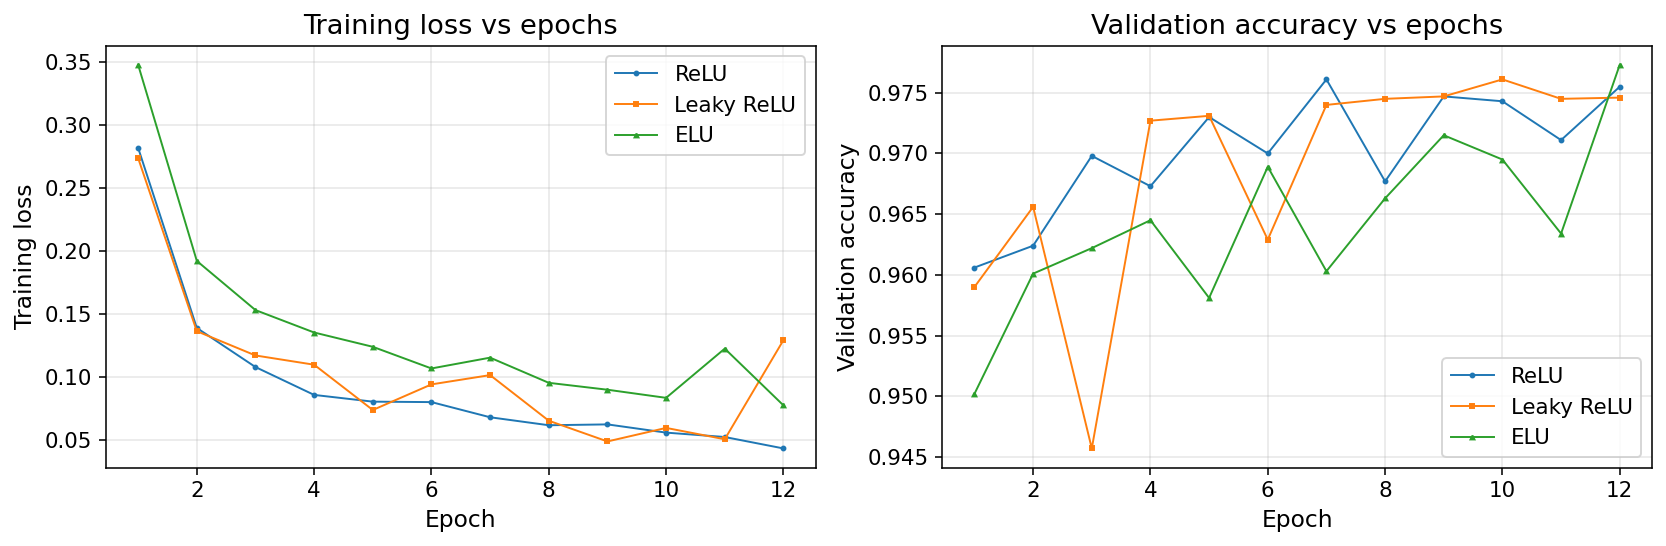

In [ ]:
epochs_range = range(1, EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=140)

# Training loss
axes[0].plot(epochs_range, relu_history["loss"], marker="o", linewidth=1, markersize=2, label="ReLU")
axes[0].plot(epochs_range, leaky_history["loss"], marker="s", linewidth=1, markersize=2, label="Leaky ReLU")
axes[0].plot(epochs_range, elu_history["loss"], marker="^", linewidth=1, markersize=2, label="ELU")

axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Training loss", fontsize=12)
axes[0].set_title("Training loss vs epochs", fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(labelsize=11)
axes[0].legend(fontsize=11)

# Validation accuracy
axes[1].plot(epochs_range, relu_history["val_accuracy"], marker="o", linewidth=1, markersize=2, label="ReLU")
axes[1].plot(epochs_range, leaky_history["val_accuracy"], marker="s", linewidth=1, markersize=2, label="Leaky ReLU")
axes[1].plot(epochs_range, elu_history["val_accuracy"], marker="^", linewidth=1, markersize=2, label="ELU")

axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Validation accuracy", fontsize=12)
axes[1].set_title("Validation accuracy vs epochs", fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(labelsize=11)
axes[1].legend(fontsize=11)

fig.tight_layout()
fig.savefig("figures/training_loss_and_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()


## Dead Neurons per Hidden Layer (ReLU Only)

This plot shows how the percentage of dead neurons evolves in **each hidden
layer** of the ReLU network.

This allows us to analyse:

- Whether deeper layers are more vulnerable
- How quickly neuron death accumulates
- Whether dead neurons ever recover


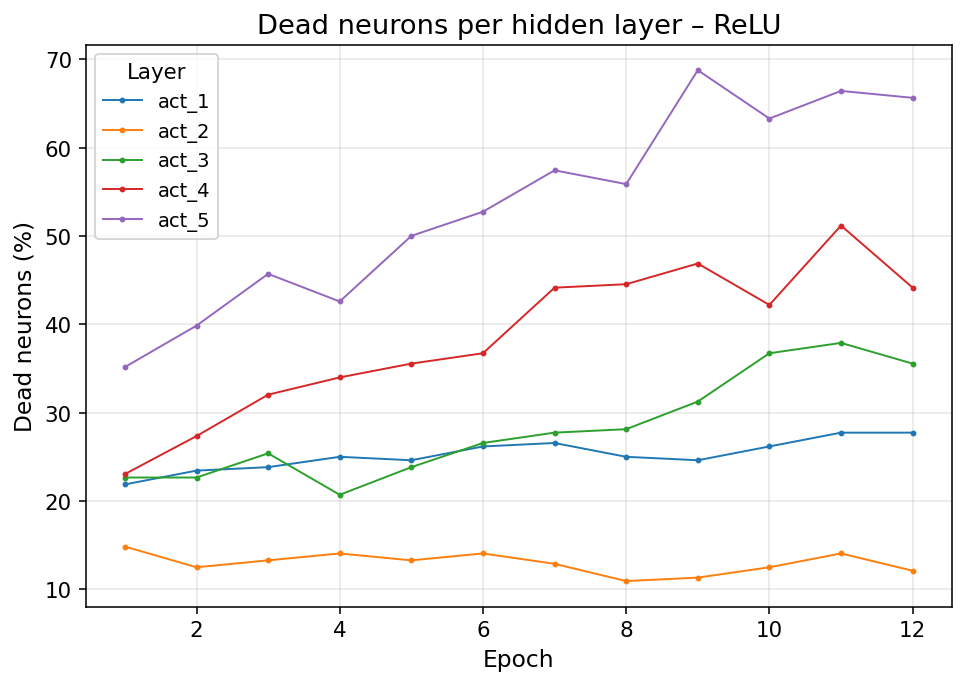

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=140)

for layer_name in relu_layers:
    ax.plot(epochs_range, relu_history["dead"][layer_name],
            marker="o", linewidth=1, markersize=2, label=layer_name)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Dead neurons (%)", fontsize=12)
ax.set_title("Dead neurons per hidden layer – ReLU", fontsize=14)
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=11)
ax.legend(title="Layer", fontsize=10, title_fontsize=11)

fig.tight_layout()
fig.savefig("figures/relu_dead_neurons_per_layer.png", dpi=300, bbox_inches="tight")
plt.show()


## Comparing Dead Neurons Across Activation Functions

We now compare the **average percentage of dead neurons** across all hidden
layers for:

- ReLU
- Leaky ReLU
- ELU

This directly demonstrates whether permanent neuron death is unique to ReLU
or whether it also occurs in alternative activation functions.


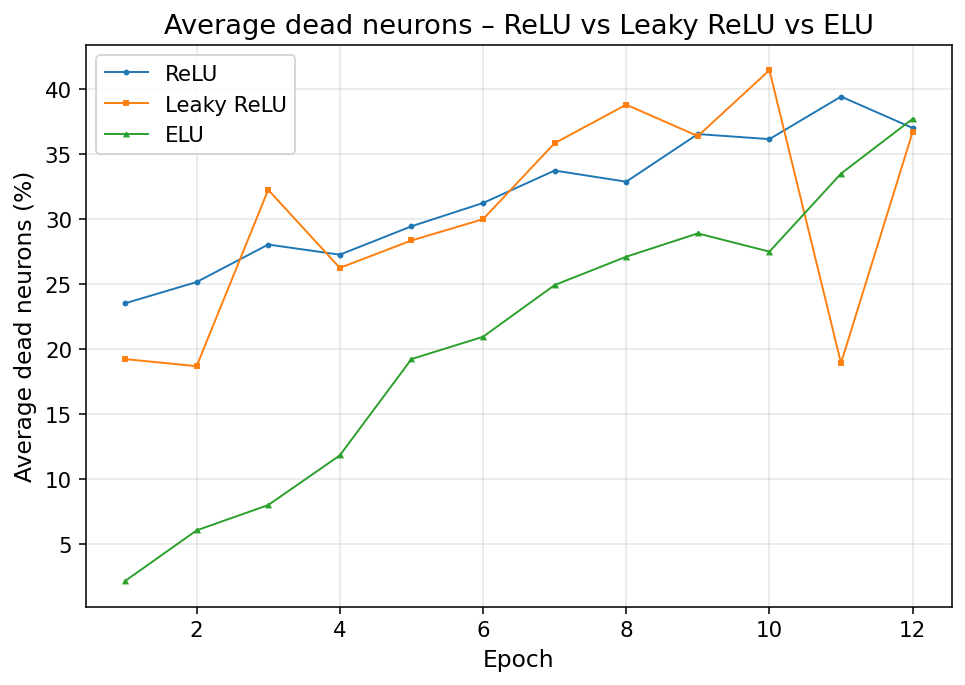

In [ ]:
def average_dead_per_epoch(history, layer_names):
    # shape: (layers, epochs)
    dead_matrix = np.array([history["dead"][name] for name in layer_names])
    return dead_matrix.mean(axis=0)

relu_dead_avg = average_dead_per_epoch(relu_history, relu_layers)
leaky_dead_avg = average_dead_per_epoch(leaky_history, leaky_layers)
elu_dead_avg = average_dead_per_epoch(elu_history, elu_layers)

fig, ax = plt.subplots(figsize=(7, 5), dpi=140)

ax.plot(epochs_range, relu_dead_avg, marker="o", linewidth=1, markersize=2, label="ReLU")
ax.plot(epochs_range, leaky_dead_avg, marker="s", linewidth=1, markersize=2, label="Leaky ReLU")
ax.plot(epochs_range, elu_dead_avg, marker="^", linewidth=1, markersize=2, label="ELU")

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Average dead neurons (%)", fontsize=12)
ax.set_title("Average dead neurons – ReLU vs Leaky ReLU vs ELU", fontsize=14)
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=11)
ax.legend(fontsize=11)

fig.tight_layout()
fig.savefig("figures/dead_neurons_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


## Visualising Internal Neuron Activations with Heatmaps

To visually confirm neuron death, we plot **activation heatmaps** where:

- Rows represent individual neurons
- Columns represent different input samples
- Colour intensity represents activation values

Dead neurons appear as **horizontal dark bands** across the entire plot.


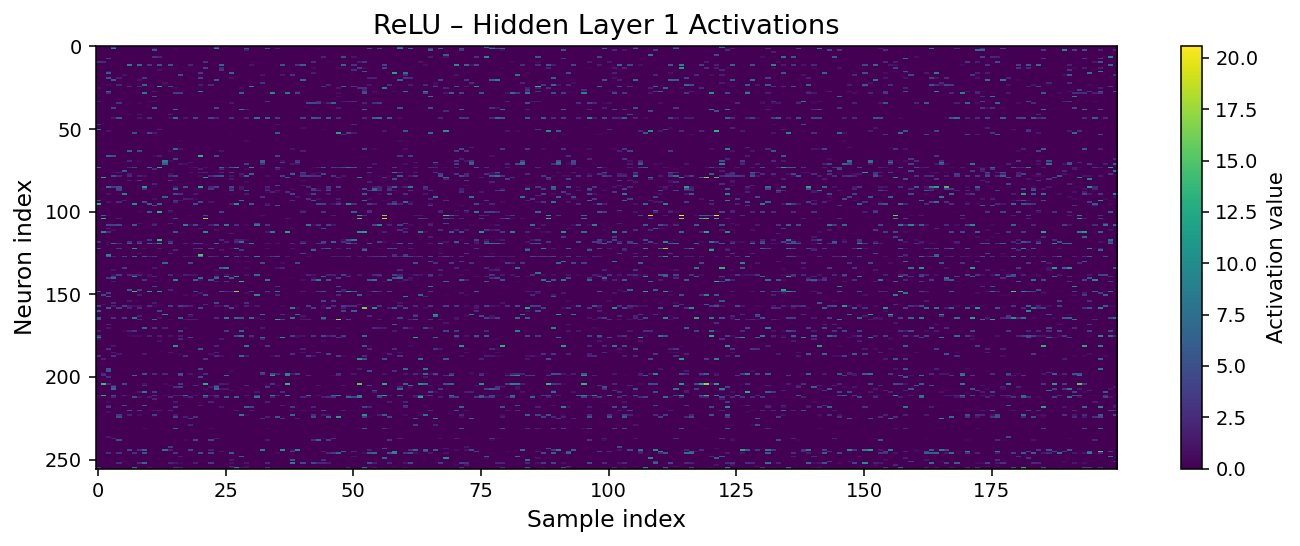

In [ ]:
def plot_activation_heatmap(model, layer_name, x_samples, title=None, filename=None):
    layer = model.get_layer(layer_name)
    temp_model = keras.Model(inputs=model.input, outputs=layer.output)

    activations = temp_model.predict(x_samples, verbose=0).T  # (units, samples)

    fig, ax = plt.subplots(figsize=(10, 4), dpi=140)
    im = ax.imshow(activations, aspect="auto", interpolation="nearest", cmap="viridis")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Activation value", fontsize=11)

    ax.set_xlabel("Sample index", fontsize=12)
    ax.set_ylabel("Neuron index", fontsize=12)
    ax.set_title(title or f"Activations – {layer_name}", fontsize=14)
    ax.tick_params(labelsize=10)

    fig.tight_layout()
    if filename is not None:
        fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# use first 200 training samples
x_samples = x_train[:200]

plot_activation_heatmap(
    relu_model,
    relu_layers[0],
    x_samples,
    title="ReLU – Hidden Layer 1 Activations",
    filename="figures/relu_layer1_heatmap.png",
)


## Final Summary

In this notebook, we demonstrated the dying ReLU problem both quantitatively
and visually. We showed that:

- ReLU networks progressively accumulate permanently inactive neurons
- Dead neurons do not recover once gradients become zero
- Leaky ReLU and ELU prevent neuron death by preserving non-zero gradients
- Internal activation heatmaps clearly reveal dead neurons in ReLU networks

These results support the mathematical analysis presented in the accompanying
tutorial report.
